In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

In [9]:
path = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/C2'
from mlpython.breaking import simple_mapping, get_bins
ds = xr.open_dataset(path + '/series.nc', chunks={'t':100})

In [11]:
ds

<xarray.Dataset>
Dimensions:  (t: 801, x: 1024, y: 1024)
Coordinates:
  * t        (t) float64 100.0 100.1 100.2 100.3 ... 179.7 179.8 179.9 180.0
  * x        (x) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
  * y        (y) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
Data variables:
    eta      (t, x, y) float32 dask.array<chunksize=(100, 1024, 1024), meta=np.ndarray>
    ux       (t, x, y) float32 dask.array<chunksize=(100, 1024, 1024), meta=np.ndarray>
    uy       (t, x, y) float32 dask.array<chunksize=(100, 1024, 1024), meta=np.ndarray>
    ke       (t) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    gpe      (t) float32 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    sourcepath:  /projects/DEIKE/jiarongw/multilayer/JFM/field_new_200m_P0.01...
    L:           200
    P:           0.01
    Re:          40000
    LEVEL:       10
    NL:          15
    rand:        2
    Htheta:      0.503
    H:           40.0
    label:       C2

In [10]:
# Use threads for parallelization
from dask.distributed import Client
client = Client(processes=False)  # threads only
print(client.dashboard_link)  # View the dashboard at the provided link
# http://localhost:8787/status

http://172.20.202.219:53462/status


/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53462 instead
  warnings.warn(


In [5]:
delta = ds.attrs['L']/2**ds.attrs['LEVEL'] # Normalize the curvature by grid size
kp = 2*np.pi/ds.attrs['L']*5
threshold = -3*kp
bins = get_bins(kp)
bins_center = bins[1:] - (bins[2] - bins[1])/2

/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_48412/4146617709.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  hist = xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/breaking.py:8: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma, order='rc')


In [24]:
hist = xr.apply_ufunc (
    simple_mapping,
    ds.eta, 
    ds.ux,  
    ds.uy,
    input_core_dims=[['x','y'], ['x','y'], ['x','y']],  # Core dimensions for each input
    output_core_dims=[['c']],  # Core dimensions for the output
    # exclude_dims=set(('zl',)),
    output_sizes={'c': len(bins_center)},
    output_dtypes=['float32'],
    vectorize=True,  # Enable vectorization
    dask="parallelized",  # Parallelize using Dask if the data is large
    kwargs={'delta':delta, 'bins':bins, 'method':0, 'threshold':threshold} 
)

/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_48412/4146617709.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  hist = xr.apply_ufunc (


In [26]:
hist.isel(t=1).compute()

/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/breaking.py:8: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma, order='rc')


<xarray.DataArray (c: 38)>
array([ 0.,  0., 10.,  1., 54., 66., 41., 12.,  4.,  4.,  6.,  2.,  2.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      dtype=float32)
Coordinates:
    t        float64 100.1
Dimensions without coordinates: c

2025-01-04 20:48:02,024 - tornado.application - ERROR - Uncaught exception GET /workers/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/workers/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/tornado/web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
  File "/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [ ]:
hist = hist.compute().assign_coords(c=bins_center)

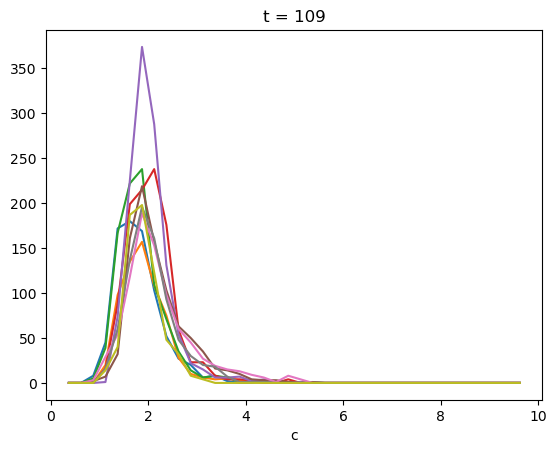

In [25]:
for i in range(hist.sizes['t']):
    hist.isel(t=i).plot(x='c')   

In [35]:
hist

<xarray.DataArray (t: 9, c: 38)>
array([[  0.,   0.,   8.,  45., 172., 180., 169., 103.,  52.,  27.,  20.,
          6.,   8.,   2.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  20.,  98., 135., 157., 108.,  75.,  28.,  10.,
          6.,   4.,   5.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   5.,  39., 167., 222., 238., 109.,  71.,  35.,  14.,
          6.,   8.,   6.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  16.,  88., 199., 215., 238., 176.,  59.,  23.,
         23.,   8.,   4.,   4.,   3.,   0.,   0.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   1.,  74., 225., 374., 288., 131.,  54.,  22.,
         15.,   6.,   6.,   7.,   2.,   4.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   2.,   7.,  32., 161., 219., 157., 103.,  63.,  50.,
         35.,  16.,  14.,  10.,   4.,   3.,   3.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   3.,  29.,  54., 118., 189., 153.,  98.,  60.,  45.,
         27.,  19.,  15.,  13.,   9.,   6.,   1.,   8.,   4.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  16.,  60., 137., 196., 161.,  93.,  48.,  30.,
         20.,  18.,   7.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  14.,  40., 187., 198., 123.,  48.,  32.,   8.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * t        (t) int64 101 102 103 104 105 106 107 108 109
  * c        (c) float64 0.375 0.625 0.875 1.125 ... 8.875 9.125 9.375 9.625

In [59]:
#### Define time window, sampling interval, and a few metadata ####
time = np.arange(100,180.1,0.1)
Nt = len(time)
path = '/projects/DEIKE/jiarongw/multilayer/JFM/field_new_200m_P0.008_RE40000_10_15_rand2_Htheta0.503/' # Change to config 
N = 1024 # Change to config  
L0 = 200 # Change to config

#### Read in 2D fields ####
fieldnames = ['eta','ux','uy']
fields = []
for fieldname in fieldnames:
    f_series = np.zeros((Nt,N,N), dtype=np.float32)
    for i in range(0, Nt):
        filename = path + f'surface/{fieldname}_matrix_%g' %time[i]
        f = np.fromfile(filename, dtype=np.float32)
        f = f.reshape(N+1,N+1); f = f[1:,1:]
        f_series[i] = f  
    fields.append(f_series)    
    
x_mesh = np.linspace(-L0/2, L0/2, N+1, endpoint=True)
ds = xr.Dataset(data_vars={name: (['t','x','y'], array) for name, array in zip(fieldnames, fields)},
                coords={'t': (['t'], time),
                        'x': (['x'], 0.5*(x_mesh[:-1]+x_mesh[1:])),
                        'y': (['y'], 0.5*(x_mesh[:-1]+x_mesh[1:]))},)
                # attrs=dict(sourcepath=field_path, **config))

In [60]:
#### Read in energy and interpolate onto surface field time ####
energy = pd.read_table(path +'energy_after_remap.dat', delimiter=' ', names=['t','ke','gpe'])
energy = energy.drop_duplicates(subset=['t'])
df = energy.set_index('t'); ds_energy = df.to_xarray()
ds['ke'] = ds_energy.ke.interp(t=ds.t)
ds['gpe'] = ds_energy.gpe.interp(t=ds.t)

In [61]:
filename = './series.nc'
encoding = {}
for var_name in ds.data_vars:
    encoding[var_name] = {'dtype': 'float32', 'zlib': True}
ds.to_netcdf(filename, encoding=encoding)

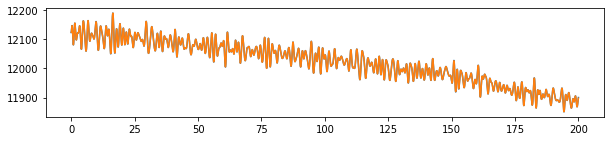

In [41]:
# energy = pd.read_table(path +'energy_after_remap.dat', delimiter=' ', names=['t','ke','gpe'])
# energy = energy.drop_duplicates(subset=['t'])
# df = energy.set_index('t'); ds = df.to_xarray()
# Bin average
# bins = np.arange(0, 200.1, 0.1) # Bin edges
# ds_resampled = ds.groupby_bins('t', bins=bins).mean()
# Or interpolate
# bins_c = np.arange(0, 200., 0.1) + 0.05  # Bin center
# ds_interped = ds.interp(t=bins_c)
fig = plt.figure(figsize=[10,2])
plt.plot(ds.t, ds.ke)
plt.plot(bins[:-1], ds_resampled.ke)
plt.plot(bins_c, ds_interped.ke)

In [65]:
ds_new = xr.open_dataset('/projects/DEIKE/jiarongw/multilayer/JPO/processed/C1/series.nc')

In [66]:
ds_new

<xarray.Dataset> Size: 10GB
Dimensions:  (t: 801, x: 1024, y: 1024)
Coordinates:
  * t        (t) float64 6kB 100.0 100.1 100.2 100.3 ... 179.7 179.8 179.9 180.0
  * x        (x) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
  * y        (y) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
Data variables:
    eta      (t, x, y) float32 3GB ...
    ux       (t, x, y) float32 3GB ...
    uy       (t, x, y) float32 3GB ...
    ke       (t) float32 3kB ...
    gpe      (t) float32 3kB ...
Attributes:
    sourcepath:  /projects/DEIKE/jiarongw/multilayer/JFM/field_new_200m_P0.00...
    L:           200
    P:           0.008
    Re:          40000
    LEVEL:       10
    NL:          15
    rand:        2
    Htheta:      0.503
    H:           40.0
    label:       C1